In [1]:
# #@title Setup. This will take a few minutes.
!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2"

Cloning into 'JoJoGAN'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 490 (delta 31), reused 31 (delta 31), pack-reused 450
Receiving objects: 100% (490/490), 63.51 MiB | 38.73 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/JoJoGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manyl

# Importing required Python Modules

In [2]:
!pip install wandb

  Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached sentry_sdk-2.11.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)
Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
Using cached sentry_sdk-2.11.0-py2.py3-none-any.whl (303 kB)
Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_

In [3]:
import torch
from torchvision import transforms, utils
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb

## Setting Cudnn benchmark usage for PyTorch

In [4]:
torch.backends.cudnn.benchmark = True

## Imprting JoJoGAN Specific Python Modules
- These modules are loaded from the JoJoGAN GitHub repo code (local file system)

In [5]:
# JoJoGAN Specific Import
from model import *
from e4e_projection import projection as e4e_projection
from util import *

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


## Python DeepCopy



In [6]:
from copy import deepcopy

## Creating local folders for local content creation and management

In [7]:
os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Downloading 68 Shape Predictor DLIB Model to read faces from the source images
- shape_predictor_68_face_landmarks.dat.bz2

In [8]:
# @title Download models

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


--2024-07-28 07:49:01--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  66.2MB/s    in 0.9s    

2024-07-28 07:49:02 (66.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [9]:
!ls -lah /content/JoJoGAN/models

total 96M
drwxr-xr-x  2 root root 4.0K Jul 28 07:49 .
drwxr-xr-x 12 root root 4.0K Jul 28 07:49 ..
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat


## Various Face Style JoJoGAN specific prebuilt models definition

In [10]:
drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# **Google Colab Dependency**

Use the following if you would want to use this code in Google Colab and use Google Drive Authentication

In [11]:
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [13]:
# #@markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = True


In [14]:
# from StyelGAN-NADA
class GDrive_Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst

In [15]:
# #downloader = Downloader(download_with_pydrive)
# downloader = GDrive_Downloader(use_pydrive=download_with_pydrive)
# downloader.download_file('stylegan2-ffhq-config-f.pt')
# downloader.download_file('e4e_ffhq_encode.pt')

# Downloading Models without Google Colab Dependency

In [16]:
# from StyelGAN-NADA
class Downloader(object):
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            !gdown --id $file_id -O $file_dst

In [17]:
downloader = Downloader()
downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK
From (redirected): https://drive.google.com/uc?id=1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK&confirm=t&uuid=0e2a34f3-9cc3-4ddc-92b5-0a4c53308178
To: /content/JoJoGAN/models/stylegan2-ffhq-config-f.pt
100% 381M/381M [00:06<00:00, 60.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7
From (redirected): https://drive.google.com/uc?id=1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7&confirm=t&uuid=24b0fb7b-83f6-4543-a988-2253e8aa6bc

In [18]:
!ls -lah /content/JoJoGAN/models/

total 1.6G
drwxr-xr-x  2 root root 4.0K Jul 28 07:57 .
drwxr-xr-x 12 root root 4.0K Jul 28 07:49 ..
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat
-rw-r--r--  1 root root 1.2G Jul 28 07:57 e4e_ffhq_encode.pt
-rw-r--r--  1 root root 364M Jul 28 07:57 stylegan2-ffhq-config-f.pt


## Making sure to use CUDA as GPU device
- Please change it to CPU if you dont have GPU

In [19]:
device = 'cuda' # ['cuda', 'cpu']

## Loading StyleGAN model
- Already trained using FFHQ dataset - 70K faces
- https://github.com/NVlabs/ffhq-dataset

In [20]:
latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)

transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

## Source Image Setup to extract Face
- Extract Face from source
-

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


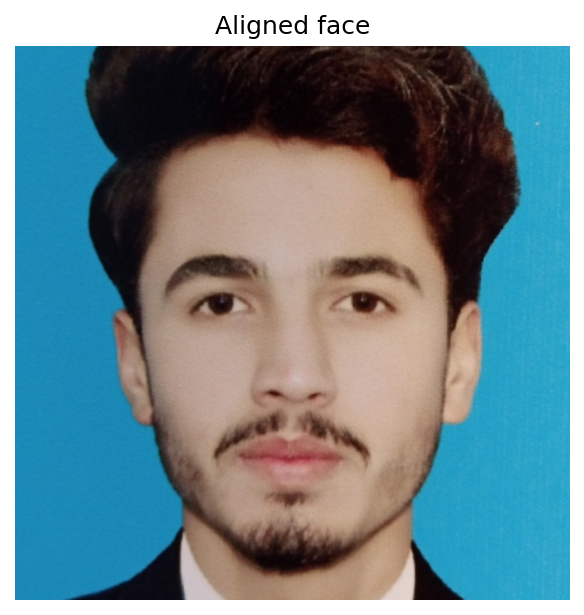

In [22]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
#filename = 'iu.jpeg' #@param {type:"string"}

filename = 'hassan.jpeg' #@param {type:"string"}

filepath = f'test_input/{filename}'


# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face from the source image
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

In [39]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'sketch_multi' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = True #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD
From (redirected): https://drive.google.com/uc?id=1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD&confirm=t&uuid=ce650939-3626-4c29-8fa2-97b4c6177645
To: /content/JoJoGAN/models/sketch_multi.pt
100% 133M/133M [00:02<00:00, 65.5MB/s]


In [40]:
!ls -lah /content/JoJoGAN/models/

total 1.9G
drwxr-xr-x  2 root root 4.0K Jul 28 08:33 .
drwxr-xr-x 13 root root 4.0K Jul 28 08:04 ..
-rw-r--r--  1 root root 127M Jul 28 08:06 disney_preserve_color.pt
-rw-r--r--  1 root root  96M Jul 24  2015 dlibshape_predictor_68_face_landmarks.dat
-rw-r--r--  1 root root 1.2G Jul 28 07:57 e4e_ffhq_encode.pt
-rw-r--r--  1 root root 127M Jul 28 08:33 sketch_multi.pt
-rw-r--r--  1 root root 364M Jul 28 07:57 stylegan2-ffhq-config-f.pt


In [41]:
ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

<All keys matched successfully>

In [42]:
torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

/content/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.3.1+cu121. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


In [43]:
# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'style_images_aligned/sketch.png'
else:
    style_path = f'style_images_aligned/{pretrained}.png'

In [44]:
style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

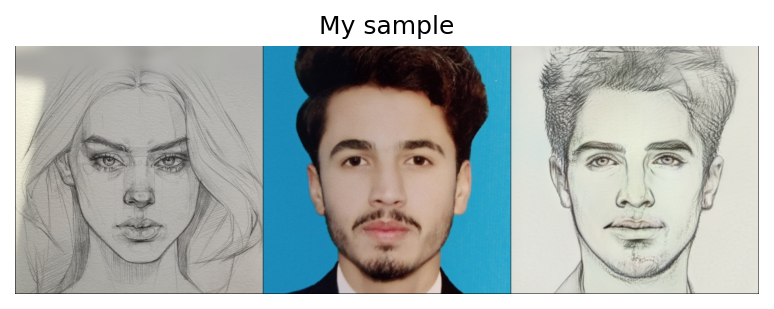

In [45]:
# my_output = torch.cat([style_image, face, my_sample], 0)
# display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True), title='My sample')


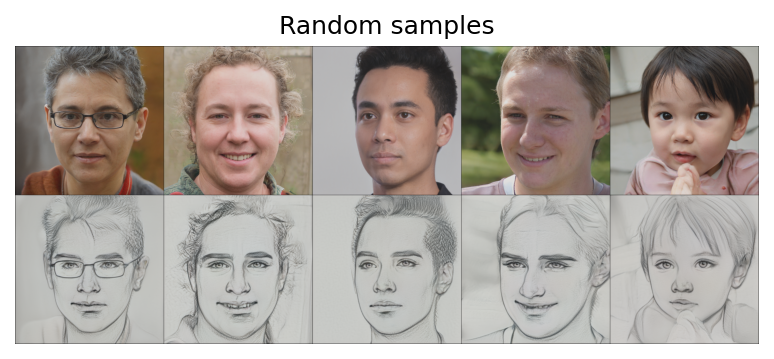

In [46]:
# output = torch.cat([original_sample, sample], 0)
# display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, nrow=n_sample), title='Random samples')
